# Flash responses

This notebook introduces flash responses and the flash response index (FRI). 

The FRI measures whether a cell depolarizes to bright or to dark increments in a visual input.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [1]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [2]:
# @markdown **Install Flyvis**
if IN_COLAB:
    !git clone https://github.com/TuragaLab/flyvis.git
    %cd /content/flyvis
    !pip install -e .[examples]

## Flash stimuli

To elicit flash responses, experimenters show a flashing dot to the subject in the center of their field of view. We generate and render these stimuli with the `Flashes` dataset.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch


from flyvis.analysis.animations.hexscatter import HexScatter
from flyvis.datasets.flashes import Flashes

In [4]:
# initialize dataset
dataset = Flashes(
    dynamic_range=[0, 1],  # min and max pixel intensity values, must be in range [0, 1]
    t_stim=1.0,  # duration of flash
    t_pre=1.0,  # duration of period between flashes
    dt=1 / 200,  # temporal resolution of rendered video
    radius=[-1, 6],  # radius of flashing dot. -1 fills entire field of view
    alternations=(0, 1, 0),  # flashing pattern, off - on - off
)

In [5]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

,baseline,intensity,radius
0,0.5,0,-1
1,0.5,0,6
2,0.5,1,-1
3,0.5,1,6


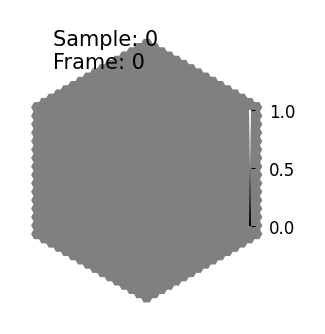

In [6]:
# visualize single sample
animation = HexScatter(
    dataset[3][None, ::50, None], vmin=0, vmax=1
)  # intensity=1, radius=6
animation.animate_in_notebook()

## Network flash response

Now that we have generated the stimulus, we can use it to drive a trained connectome-constrained network.

In [7]:
from flyvis import results_dir
from flyvis import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-12-08 19:35:35] network_view:122 Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000


In [8]:
stims_and_resps = network_view.flash_responses(dataset=dataset)

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/577e21fdb69e8a7bf543369fa02dc2aa/output.h5


Text(0.5, 1.0, 'L1 flash responses')

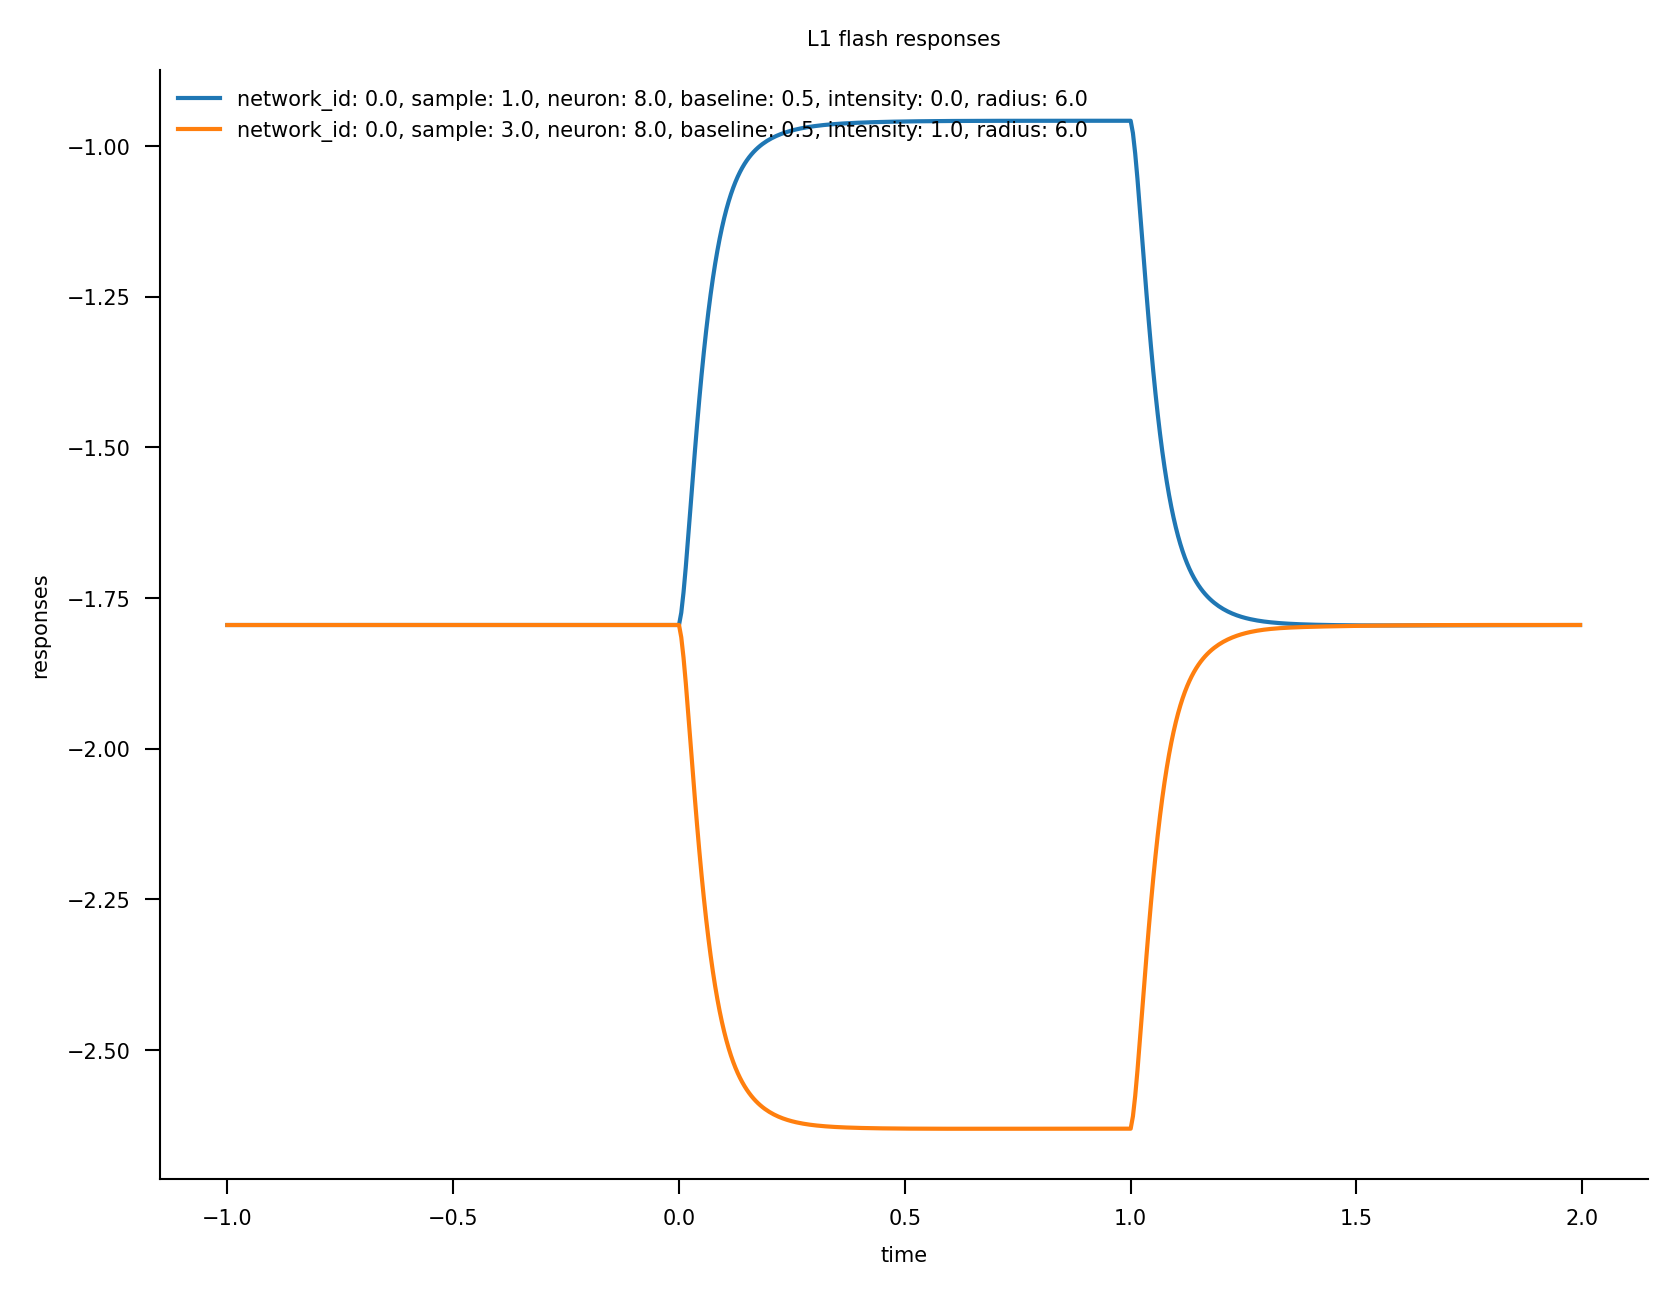

In [9]:
stims_and_resps['responses'].custom.where(cell_type="L1", radius=6).custom.plot_traces(
    x='time'
)
fig = plt.gcf()
fig.axes[-1].set_title("L1 flash responses")

### Flash response index (FRI)

The flash response index (FRI) is a measure of the strength of contrast tuning of a particular cell. It is computed as the difference between the cell's peak voltage in response to on-flashes (intensity = 1) and off-flashes (intensity = 0), divided by the sum of those peak values.

That is, given a single neuron's response to on-flashes `r_on` and off-flashes `r_off` (both of `shape=(T,)`), we can compute the flash response index with

```
r_on_max = max(r_on)
r_off_max = max(r_off)
fri = (r_on_max - r_off_max) / (r_on_max + r_off_max + 1e-16)
```

with the additional `1e-16` simply for numerical stability. Before this calculation, the response traces are shifted to be non-negative.

The flash response index can take on values between $-1$, when the off response is much stronger (or more positive) than the on response, to $1$, when the on response is much stronger (or more positive) than the off response.

For the L1 cell plotted before, we can see that it displays a positive response to off flashes and a negative response to on flashes, so we expect a negative flash response index.

In [10]:
from flyvis.analysis.flash_responses import flash_response_index

In [11]:
fris = flash_response_index(stims_and_resps, radius=6)

In [12]:
fris.custom.where(cell_type="L1")

<xarray.DataArray 'responses' (network_id: 1, sample: 1, neuron: 1)>
array([[[-0.33354023]]], dtype=float32)
Coordinates:
    baseline      (sample) float64 0.5
    radius        (sample) int32 6
  * neuron        (neuron) int64 8
    cell_type     (neuron) <U8 'L1'
    u             (neuron) int32 0
    v             (neuron) int32 0
  * network_id    (network_id) int64 0
    network_name  (network_id) <U13 'flow/0000/000'
    checkpoints   (network_id) object /groups/turaga/home/lappalainenj/FlyVis...
Dimensions without coordinates: sample

### FRI correlation

Since the tuning of some cell types have been determined experimentally, we can then compare our model to experimental findings by computing the correlation between the model FRIs for known cell types with their expected tuning.

In [13]:
from flyvis.analysis.flash_responses import fri_correlation_to_known
from flyvis.utils.groundtruth_utils import polarity

In [14]:
fri_corr = fri_correlation_to_known(fris)

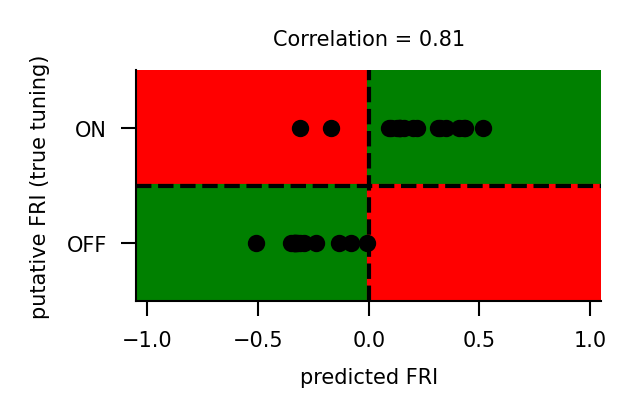

In [15]:
# manually extract model and true FRIs for plotting
known_cell_types = [k for k, v in polarity.items() if v != 0]
model_fris = [fris.custom.where(cell_type=k).item() for k in known_cell_types]
true_fris = [polarity[k] for k in known_cell_types]
# plot
plt.figure(figsize=[2, 1])
plt.scatter(model_fris, true_fris, color="k", s=10)
plt.xlabel("predicted FRI")
plt.ylabel("putative FRI (true tuning)")
plt.axvline(0, linestyle="--", color="black")
plt.axhline(0, linestyle="--", color="black")

plt.axhspan(0, 2, 0, 0.5, color="red", zorder=-10)
plt.axhspan(0, 2, 0.5, 1.0, color="green", zorder=-10)
plt.axhspan(-2, 0, 0, 0.5, color="green", zorder=-10)
plt.axhspan(-2, 0, 0.5, 1.0, color="red", zorder=-10)

plt.xlim(-1.05, 1.05)
plt.ylim(-2, 2)
plt.title(f"Correlation = {fri_corr[0].item():.2g}")
plt.yticks([-1, 1], ["OFF", "ON"])
plt.show()

As we can see, for all except two cell types, the model correctly predicts the cell's tuning (positive or negative).

## Ensemble responses

Now we can compare tuning properties across an ensemble of trained models. First we need to again simulate the network responses.

In [16]:
from flyvis import EnsembleView

ensemble = EnsembleView("flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-12-08 19:35:48] ensemble:166 Loaded 50 networks.


In [17]:
stims_and_resps = ensemble.flash_responses(dataset=dataset)

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/577e21fdb69e8a7bf543369fa02dc2aa/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/8178c987bed4870114f3fff7641e7fae/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/6acc3ac28e719cae7b1941fdbf745ab6/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/b412c4c9ca2a95b27e65a2e50d42467d/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/ac57e619046e24281f445a44d7971446/output.h5
/groups/turaga/home/lappalainenj/FlyVis/priva

### Response traces

We can once again plot response traces for a single cell type. We subtract the initial value of each trace to center the data before plotting, as the network neuron activities are in arbitrary units.

In [18]:
centered = (
    stims_and_resps['responses']
    - stims_and_resps['responses'].custom.where(time=0.0).values
)

Text(0.5, 1.0, 'L1 flash responses')

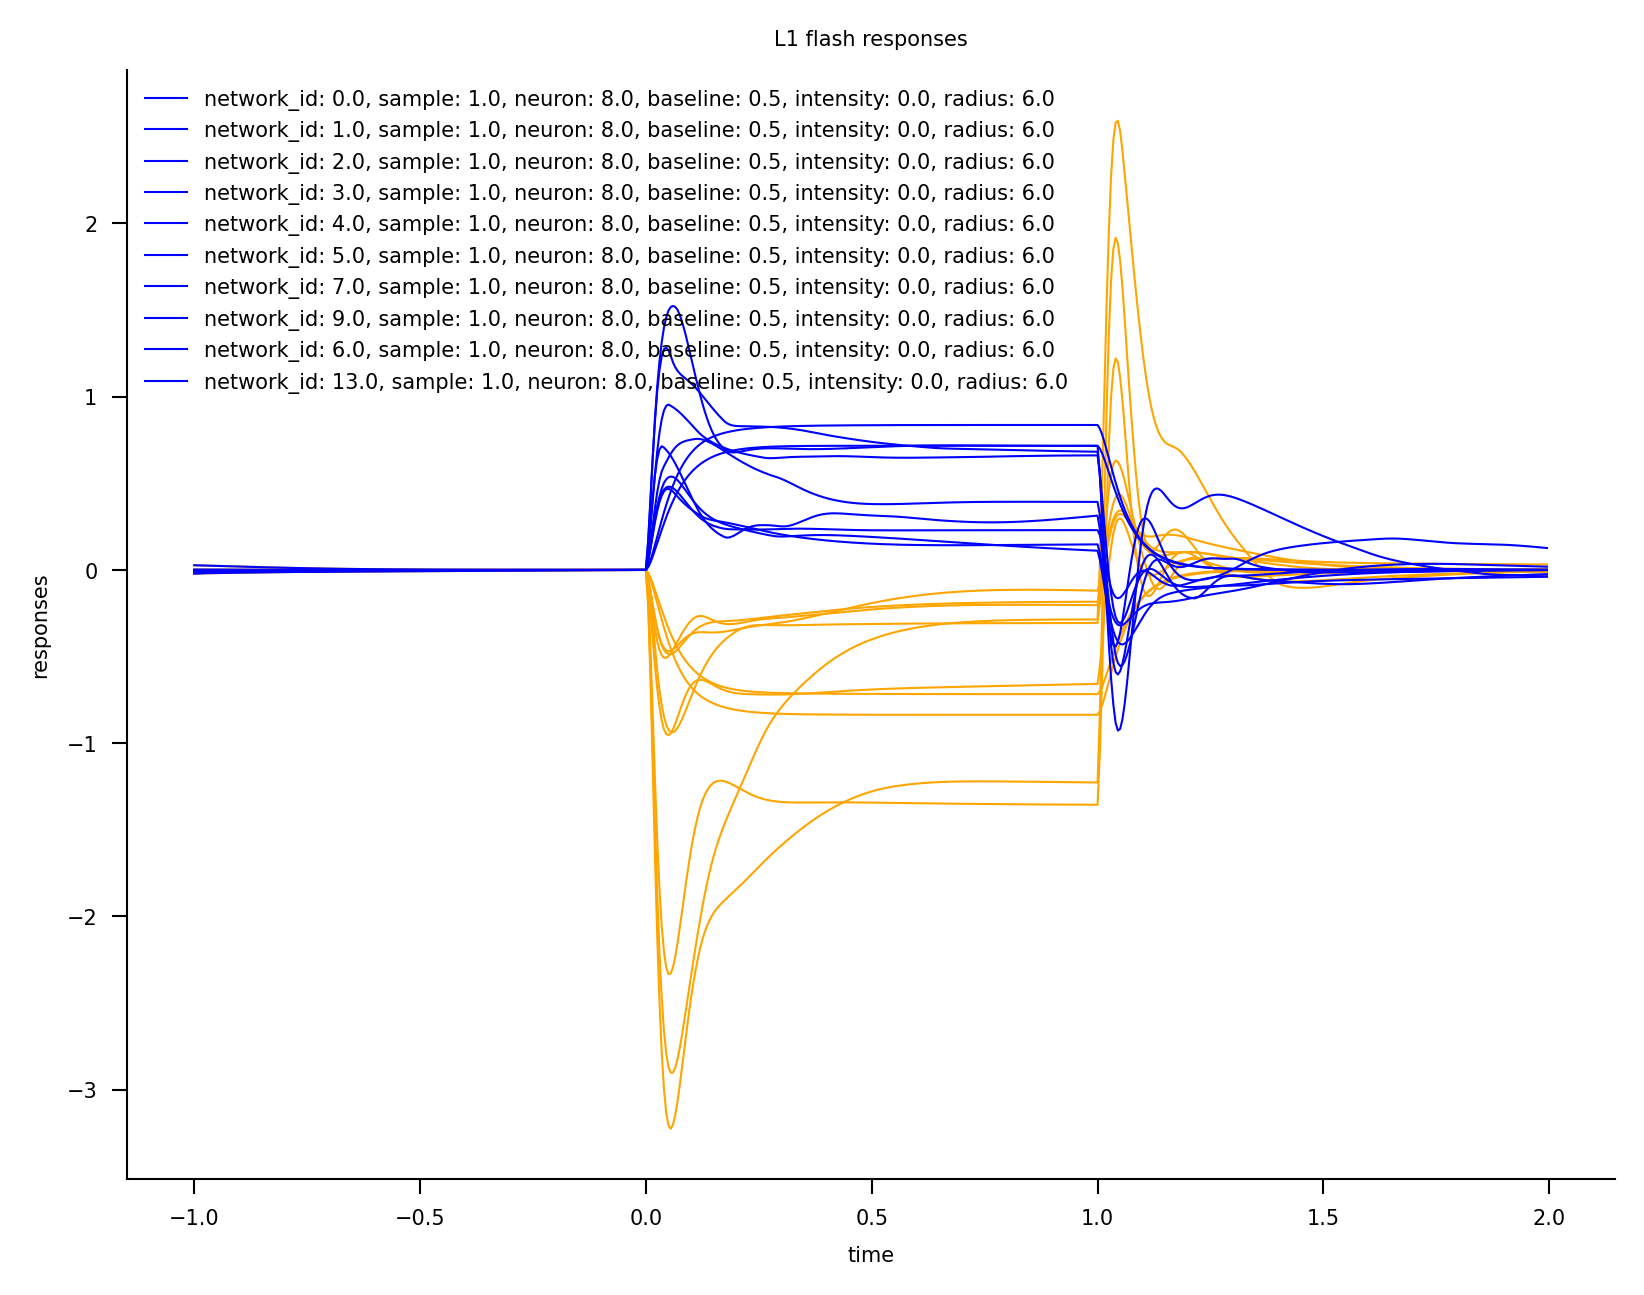

In [19]:
centered.sel(network_id=ensemble.argsort()[:10]).custom.where(
    cell_type="L1", radius=6, intensity=1
).custom.plot_traces(x='time', plot_kwargs=dict(color='orange', linewidth=0.5))
ax = plt.gca()
centered.sel(network_id=ensemble.argsort()[:10]).custom.where(
    cell_type="L1", radius=6, intensity=0
).custom.plot_traces(x='time', plot_kwargs=dict(ax=ax, color='blue', linewidth=0.5))
ax.set_title("L1 flash responses")

Though the scaling varies, all networks predict depolarization to OFF-flashes for L1.

### Flash response index (FRI)

We can also compute flash response indices for each network in the ensemble.

In [20]:
# get FRI for L1 cell

fri_l1 = (
    flash_response_index(stims_and_resps, radius=6)
    .sel(network_id=ensemble.argsort()[:10])
    .custom.where(cell_type="L1")
)
print(fri_l1.squeeze().values)

[-0.33354023 -0.28763247 -0.32586816 -0.20794408 -0.3334335  -0.32148358
 -0.3565678  -0.33286062 -0.1327389  -0.16595899]


All models recover similar flash response indices for this cell type. We can also plot the distribution of FRIs per cell type across the ensemble.

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/d9d302eebb41d955bb76dcf9d6ce623a/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/13f5d9136003d68fa860867f0ed89c64/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/6ec38263ed72b3a302f55bd519d68643/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/048c1466b844b8be367b875fab782256/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/ca0abb0d8af62ceb2b9ad8b3d991eb06/output.h5
/groups/turaga/home/lappalainenj/FlyVis/priva

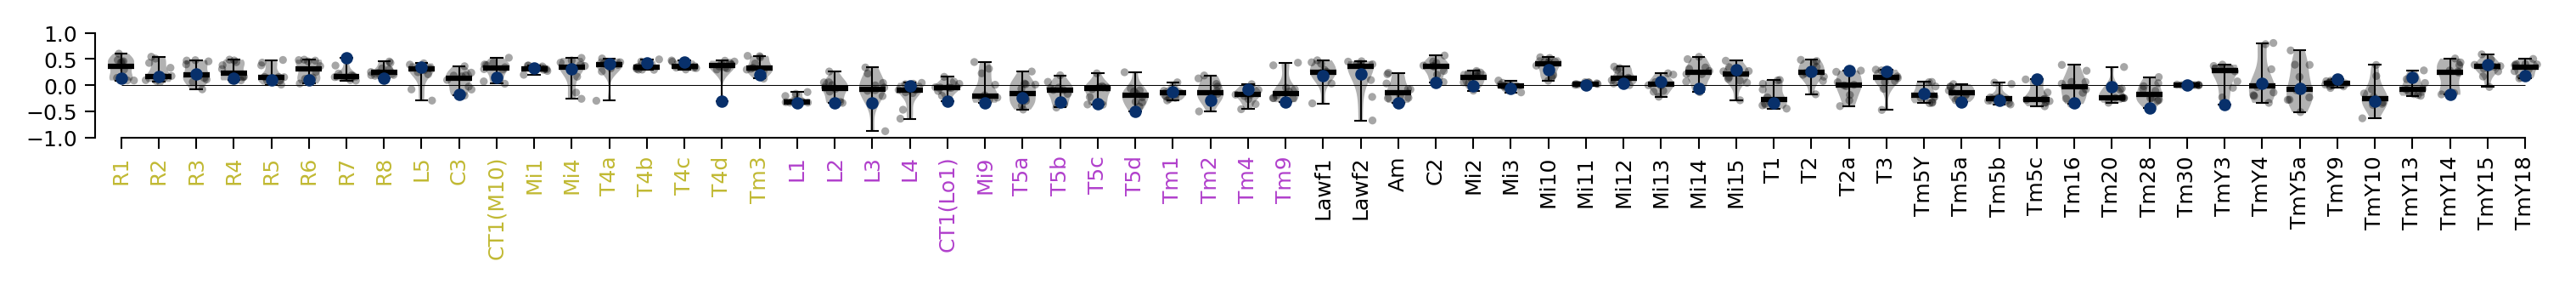

In [21]:
with ensemble.select_items(ensemble.argsort()[:10]):
    ensemble.flash_response_index()

### FRI correlation

Lastly, we look at the correlations to ground-truth tuning across the ensemble.

In [22]:
from flyvis.analysis.flash_responses import flash_response_index

In [23]:
fris = flash_response_index(stims_and_resps, radius=6)

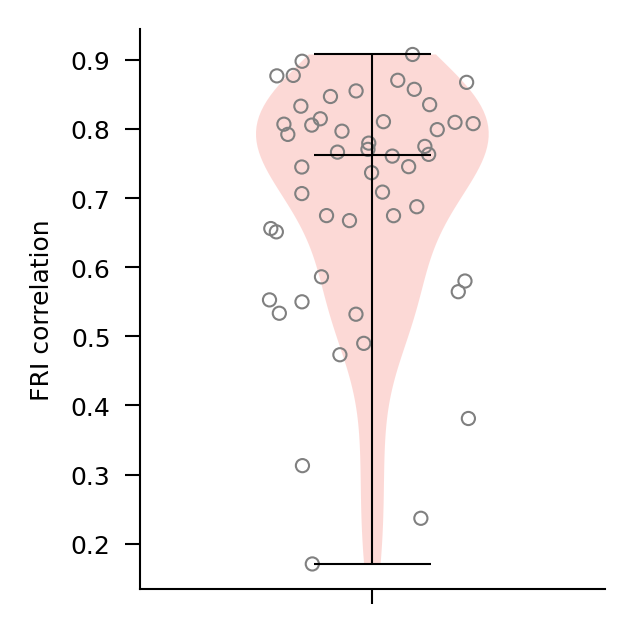

In [24]:
from flyvis.analysis.visualization.plots import violin_groups

# compute correlation
fri_corr = fri_correlation_to_known(fris)

fig, ax, *_ = violin_groups(
    np.array(fri_corr)[None, None, :].squeeze(-1),
    ylabel="FRI correlation",
    figsize=(2, 2),
    xlim=(0, 1),
    xticklabels=[],
    colors=[plt.get_cmap("Pastel1")(0.0)],
    scatter_edge_color="gray",
    scatter_radius=10,
)

Models in general have very good match to known single-neuron tuning properties, with median correlation around 0.8.